In [1]:
from manifold_learning import CCM
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import get_truncated_lorenz_rand
import numpy as np
import matplotlib.pyplot as plt
import time
import torch

### Time statistics

In [2]:

def prepare_embeddings(N_sys):
    X = np.concatenate([get_truncated_lorenz_rand(280, n_steps=30000)[:,[0]].T for _ in range(N_sys)])
    X_emb = [utils.get_td_embedding_np(x[:, None], 5, 10, return_pred=False)[:, :, 0] for x in X]
    Y_emb = [utils.get_td_embedding_np(x[:, None], 5, 10, return_pred=False)[:, [0], 0] for x in X]
    return X_emb, Y_emb

def time_ccm_computation(X_emb, Y_emb, trials=15, device="cpu"):
    
    torch.cuda.empty_cache()
    ccm = CCM.FastCCM(device=device) 

    start_time = time.time()
    for _ in range(trials):
        ccm.compute(X_emb, Y_emb, 1000, 250, 30, 10, 0)
    total_time =  time.time() - start_time
    
    avg_time = total_time / trials * 1000
    time_per_pair = avg_time / len(X_emb) / len(Y_emb)
    
    return avg_time, time_per_pair


In [3]:
timeseries_counts = [1, 2, 5, 10, 15, 20, 30, 50, 100, 150, 200, 300]

In [4]:
X_emb, Y_emb = prepare_embeddings(max(timeseries_counts))

In [6]:

results_cpu = []
for count in timeseries_counts:
    avg_time, time_per_pair = time_ccm_computation(X_emb[:count], Y_emb[:count],device="cpu")
    results_cpu += [time_per_pair]
    print(f"N_sys={count}: Avg time = {avg_time:.6f}ms, Time per pair = {time_per_pair:.6f}ms")

N_sys=1: Avg time = 4.851866ms, Time per pair = 4.851866ms
N_sys=2: Avg time = 6.741460ms, Time per pair = 1.685365ms
N_sys=5: Avg time = 9.135755ms, Time per pair = 0.365430ms
N_sys=10: Avg time = 12.938579ms, Time per pair = 0.129386ms
N_sys=15: Avg time = 16.984399ms, Time per pair = 0.075486ms
N_sys=20: Avg time = 21.341880ms, Time per pair = 0.053355ms
N_sys=30: Avg time = 28.710286ms, Time per pair = 0.031900ms
N_sys=50: Avg time = 36.105506ms, Time per pair = 0.014442ms
N_sys=100: Avg time = 84.154781ms, Time per pair = 0.008415ms
N_sys=150: Avg time = 154.139010ms, Time per pair = 0.006851ms
N_sys=200: Avg time = 242.391952ms, Time per pair = 0.006060ms
N_sys=300: Avg time = 452.910852ms, Time per pair = 0.005032ms


In [8]:

results_cuda = []
for count in timeseries_counts:
    avg_time, time_per_pair = time_ccm_computation(X_emb[:count], Y_emb[:count],device="cuda")
    results_cuda += [time_per_pair]
    print(f"N_sys={count}: Avg time = {avg_time:.6f}ms, Time per pair = {time_per_pair:.6f}ms")

N_sys=1: Avg time = 3.655005ms, Time per pair = 3.655005ms
N_sys=2: Avg time = 2.872880ms, Time per pair = 0.718220ms
N_sys=5: Avg time = 5.187575ms, Time per pair = 0.207503ms
N_sys=10: Avg time = 9.504906ms, Time per pair = 0.095049ms
N_sys=15: Avg time = 13.628928ms, Time per pair = 0.060573ms
N_sys=20: Avg time = 17.458026ms, Time per pair = 0.043645ms
N_sys=30: Avg time = 23.701541ms, Time per pair = 0.026335ms
N_sys=50: Avg time = 29.868571ms, Time per pair = 0.011947ms
N_sys=100: Avg time = 60.292021ms, Time per pair = 0.006029ms
N_sys=150: Avg time = 108.297237ms, Time per pair = 0.004813ms
N_sys=200: Avg time = 129.082203ms, Time per pair = 0.003227ms
N_sys=300: Avg time = 198.923763ms, Time per pair = 0.002210ms


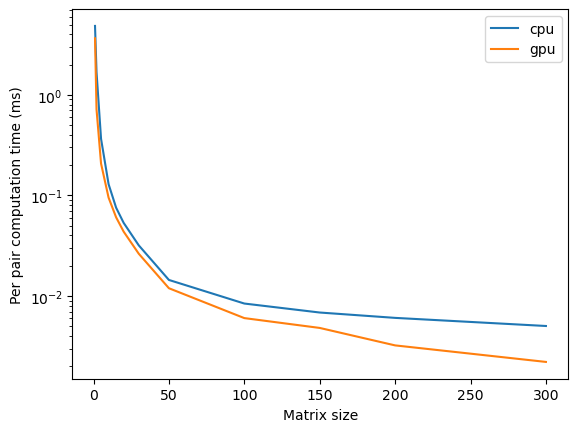

In [12]:
plt.plot(timeseries_counts, results_cpu, label="cpu")
plt.plot(timeseries_counts, results_cuda, label="gpu")
plt.yscale("log")
plt.xlabel("Matrix size")
plt.ylabel("Per pair computation time (ms)")
plt.legend()

In [10]:
torch.cuda.get_device_name()

'NVIDIA RTX 3500 Ada Generation Laptop GPU'